In [1]:
import xarray as xr
import numpy as np
import glob
import time
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from scipy.signal import detrend
from scipy.stats import pearsonr

In [2]:
# Load data

# Total column water vapor
tcwv = xr.open_dataset('/pscratch/sd/s/skygale/dyn-data/single_level_TCWV.nc').tcwv
tcwv = tcwv.sel(valid_time=slice("1980-01", "2022-12"))
tcwv_mam = tcwv.sel(valid_time=tcwv.valid_time.dt.month.isin([3, 4, 5]))

# Reshape with dask (lazy)
wv_lats = tcwv_mam.latitude.values
wv_lons = tcwv_mam.longitude.values

start = time.time()
TCWV_maps = tcwv_mam.data.reshape(43, 3, len(wv_lats), len(wv_lons))
print("Reshape time:", time.time() - start)

# Surface air temperature
SAT_paths = glob.glob('/pscratch/sd/s/skygale/observations/sat-regrid/*')
SAT_names, SAT_Arctic_data = [], []
for path in SAT_paths:
    SAT_names.append(path.split('/')[7][:-3])
    ds = xr.open_dataset(path).DATA
    SAT_Arctic_data.append(ds)
SAT_maps = np.nanmean(SAT_Arctic_data, axis=0)

# Sea level pressure
SLP_paths = glob.glob('/pscratch/sd/s/skygale/observations/slp-regrid/*')
SLP_names, SLP_Arctic_data = [], []
for path in SLP_paths:
    SLP_names.append(path.split('/')[7][:-3])
    ds = xr.open_dataset(path).DATA
    SLP_Arctic_data.append(ds)
SLP_maps = np.nanmean(SLP_Arctic_data, axis=0) / 100

# Sea ice concentration (NSIDC 0051)
SIC_maps = xr.open_dataset('../data/sic_data.nc').__xarray_dataarray_variable__

# Check dimensions
print('TCWV_maps:', TCWV_maps.shape)
print('SLP_maps: ', SLP_maps.shape)
print('SAT_maps: ', SAT_maps.shape)
print('SIC_maps: ', SIC_maps.shape)


Reshape time: 270.3544237613678
TCWV_maps: (43, 3, 721, 1440)
SLP_maps:  (43, 3, 28, 144)
SAT_maps:  (43, 3, 28, 144)
SIC_maps:  (43, 3, 24, 144)


### TCWV and SAT

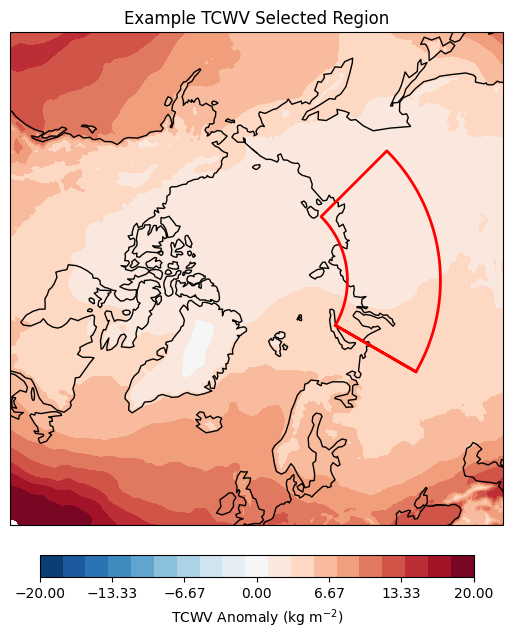

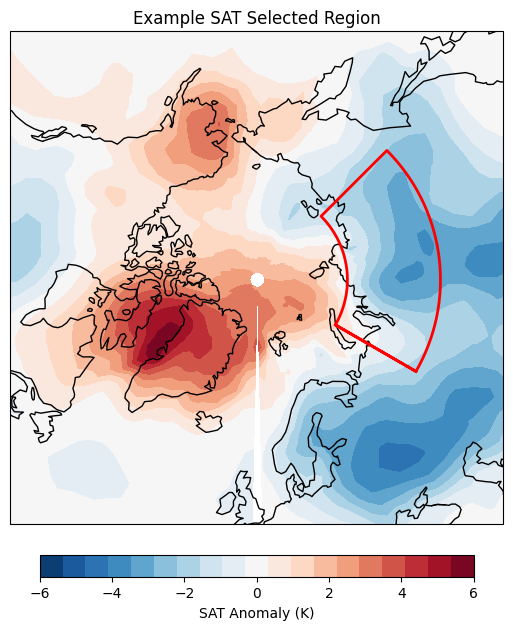

In [6]:
# Interannual correlations setup

# --- Get indices ---
def get_region_indices(lats, lons, region):
    lat_idx = (lats >= region['lat_min']) & (lats <= region['lat_max'])
    lon_idx = (lons >= region['lon_min']) & (lons <= region['lon_max'])
    return lat_idx, lon_idx


wv_lats = tcwv_mam.latitude.values
wv_lons = tcwv_mam.longitude.values
sat_lats = ds.lat.values
sat_lons = ds.lon.values

# Select region
region = {'lat_min': 60, 'lat_max': 75, 'lon_min': 60, 'lon_max': 135}

wv_lat_idx, wv_lon_idx = get_region_indices(wv_lats, wv_lons, region)
sat_lat_idx, sat_lon_idx = get_region_indices(sat_lats, sat_lons, region)

# Check on maps
region_lats = [region['lat_min'], region['lat_max'], region['lat_max'], region['lat_min'], region['lat_min']]
region_lons = [region['lon_min'], region['lon_min'], region['lon_max'], region['lon_max'], region['lon_min']]

# Smooth region
resolution = 100
lons_top = np.linspace(region['lon_min'], region['lon_max'], resolution)
lats_top = np.full_like(lons_top, region['lat_max'])
lons_bottom = np.linspace(region['lon_max'], region['lon_min'], resolution)
lats_bottom = np.full_like(lons_bottom, region['lat_min'])

lats_left = np.linspace(region['lat_max'], region['lat_min'], resolution)
lons_left = np.full_like(lats_left, region['lon_min'])
lats_right = np.linspace(region['lat_min'], region['lat_max'], resolution)
lons_right = np.full_like(lats_right, region['lon_max'])

region_lons = np.concatenate([lons_top, lons_right, lons_bottom, lons_left])
region_lats = np.concatenate([lats_top, lats_right, lats_bottom, lats_left])

# TCWV
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': ccrs.NorthPolarStereo()})
ax.set_extent([-180, 180, 50, 90], crs=ccrs.PlateCarree())

im = ax.contourf(
    wv_lons, wv_lats,
    TCWV_maps[0, 0],
    cmap="RdBu_r",
    levels=np.linspace(-20, 20, 20),
    transform=ccrs.PlateCarree()
)

cbar = fig.colorbar(im, ax=ax, orientation='horizontal', ticks=np.linspace(-20, 20, 7), shrink=0.7, pad=0.05)
cbar.set_label('TCWV Anomaly (kg m$^{-2}$)')

ax.plot(region_lons, region_lats, color='red', linewidth=2, transform=ccrs.PlateCarree())
ax.set_title('Example TCWV Selected Region')
ax.grid(alpha=0.3)
ax.coastlines()
plt.show()

# SAT
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': ccrs.NorthPolarStereo()})
ax.set_extent([-180, 180, 50, 90], crs=ccrs.PlateCarree())

im = ax.contourf(
    sat_lons, sat_lats,
    SAT_maps[0, 0],
    cmap="RdBu_r",
    levels=np.linspace(-6, 6, 20),
    transform=ccrs.PlateCarree()
)

cbar = fig.colorbar(im, ax=ax, orientation='horizontal', ticks=np.linspace(-6, 6, 7), shrink=0.7, pad=0.05)
cbar.set_label('SAT Anomaly (K)')

ax.plot(region_lons, region_lats, color='red', linewidth=2, transform=ccrs.PlateCarree())
ax.set_title('Example SAT Selected Region')
ax.grid(alpha=0.3)
ax.coastlines()
plt.show()

In [46]:
# --- Get regional average time series for each month ---
def spatial_average(array, lats):
    weights = np.cos(np.deg2rad(lats))
    weights_array = weights[np.newaxis, np.newaxis, :, np.newaxis]
    weighted_array = array * weights_array
    weighted_sum = np.nansum(weighted_array, axis=(2, 3))
    weights_sum = np.nansum(weights_array * ~np.isnan(array), axis=(2, 3))
    return weighted_sum / weights_sum


tcwv_ts = spatial_average(TCWV_maps[:, :, wv_lat_idx, :][:, :, :, wv_lon_idx], wv_lats[wv_lat_idx])
sat_ts = spatial_average(SAT_maps[:, :, sat_lat_idx, :][:, :, :, sat_lon_idx], sat_lats[sat_lat_idx])

print(np.shape(tcwv_ts), np.shape(sat_ts))

(43, 3) (43, 3)


In [47]:
# --- Detrend ---
tcwv_dt = detrend(tcwv_ts, axis=0, type='linear')
sat_dt = detrend(sat_ts, axis=0, type='linear')


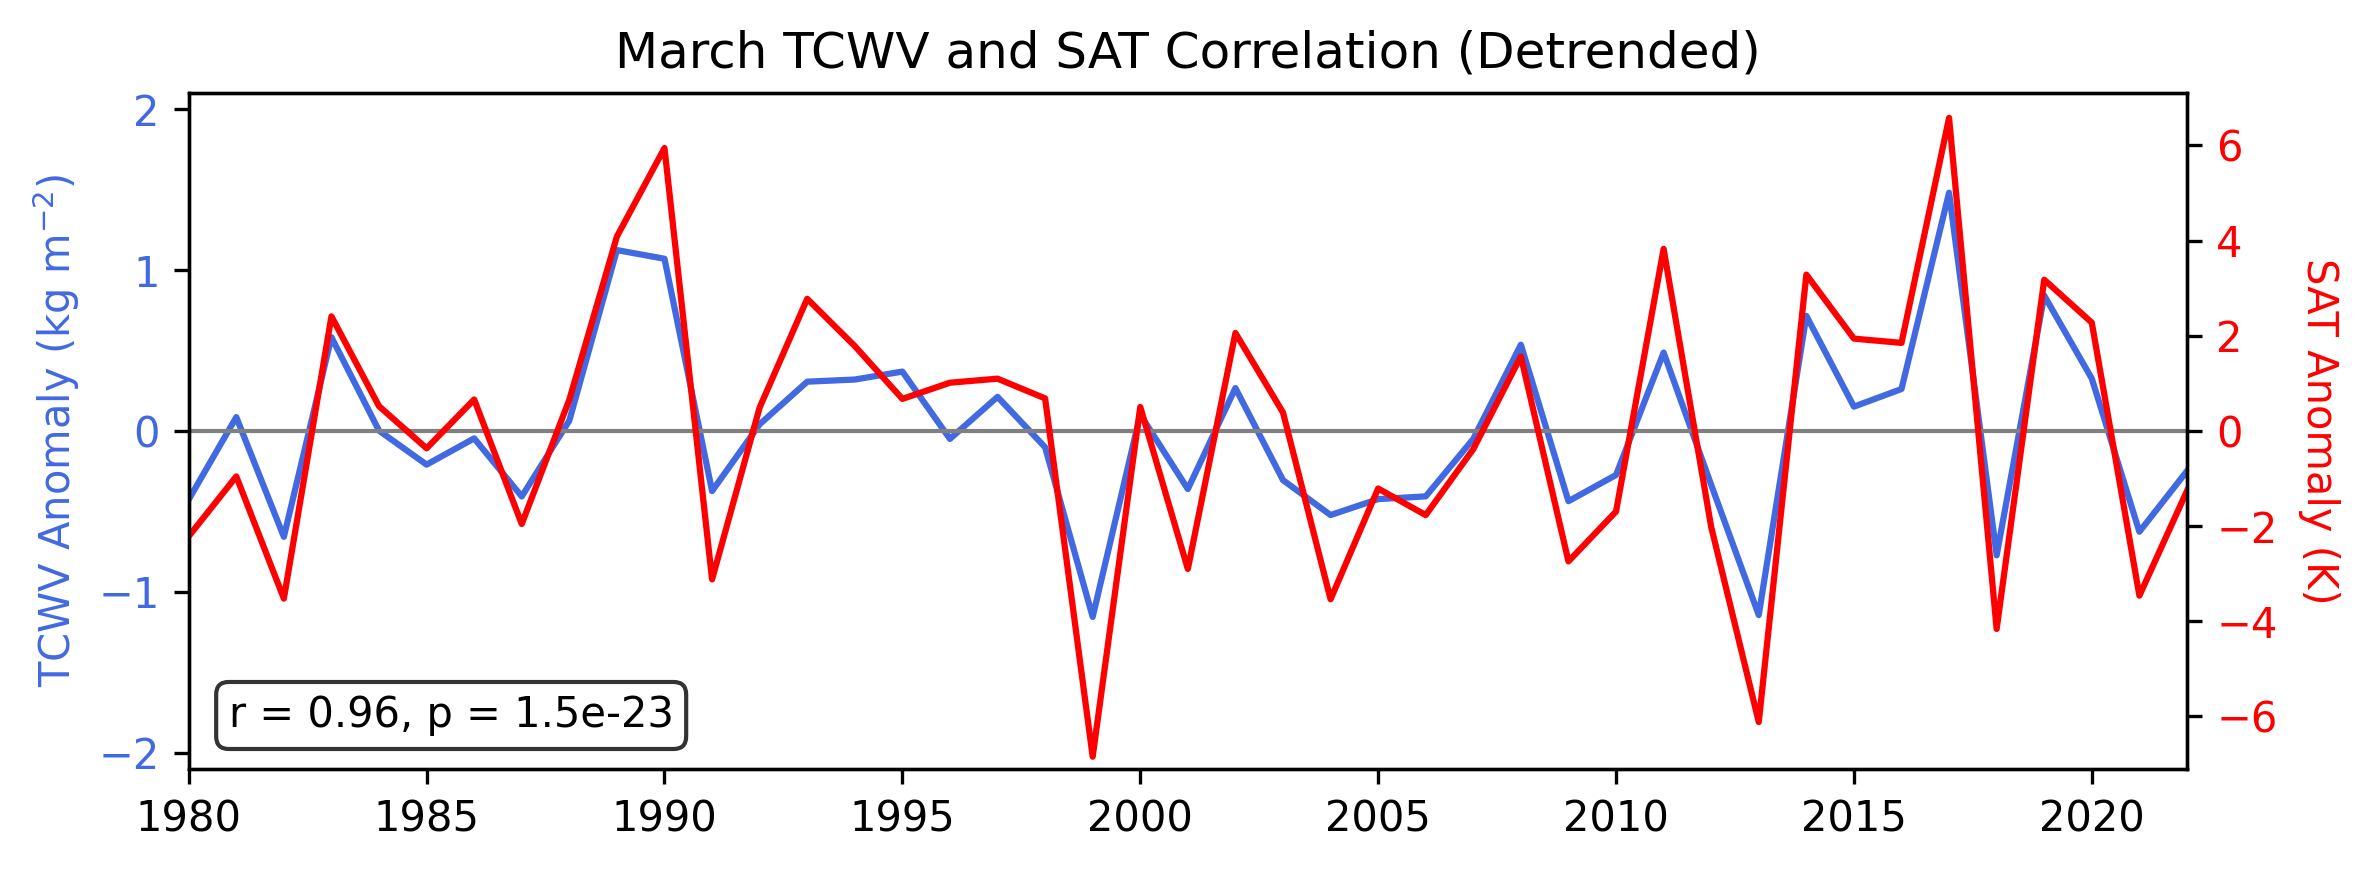

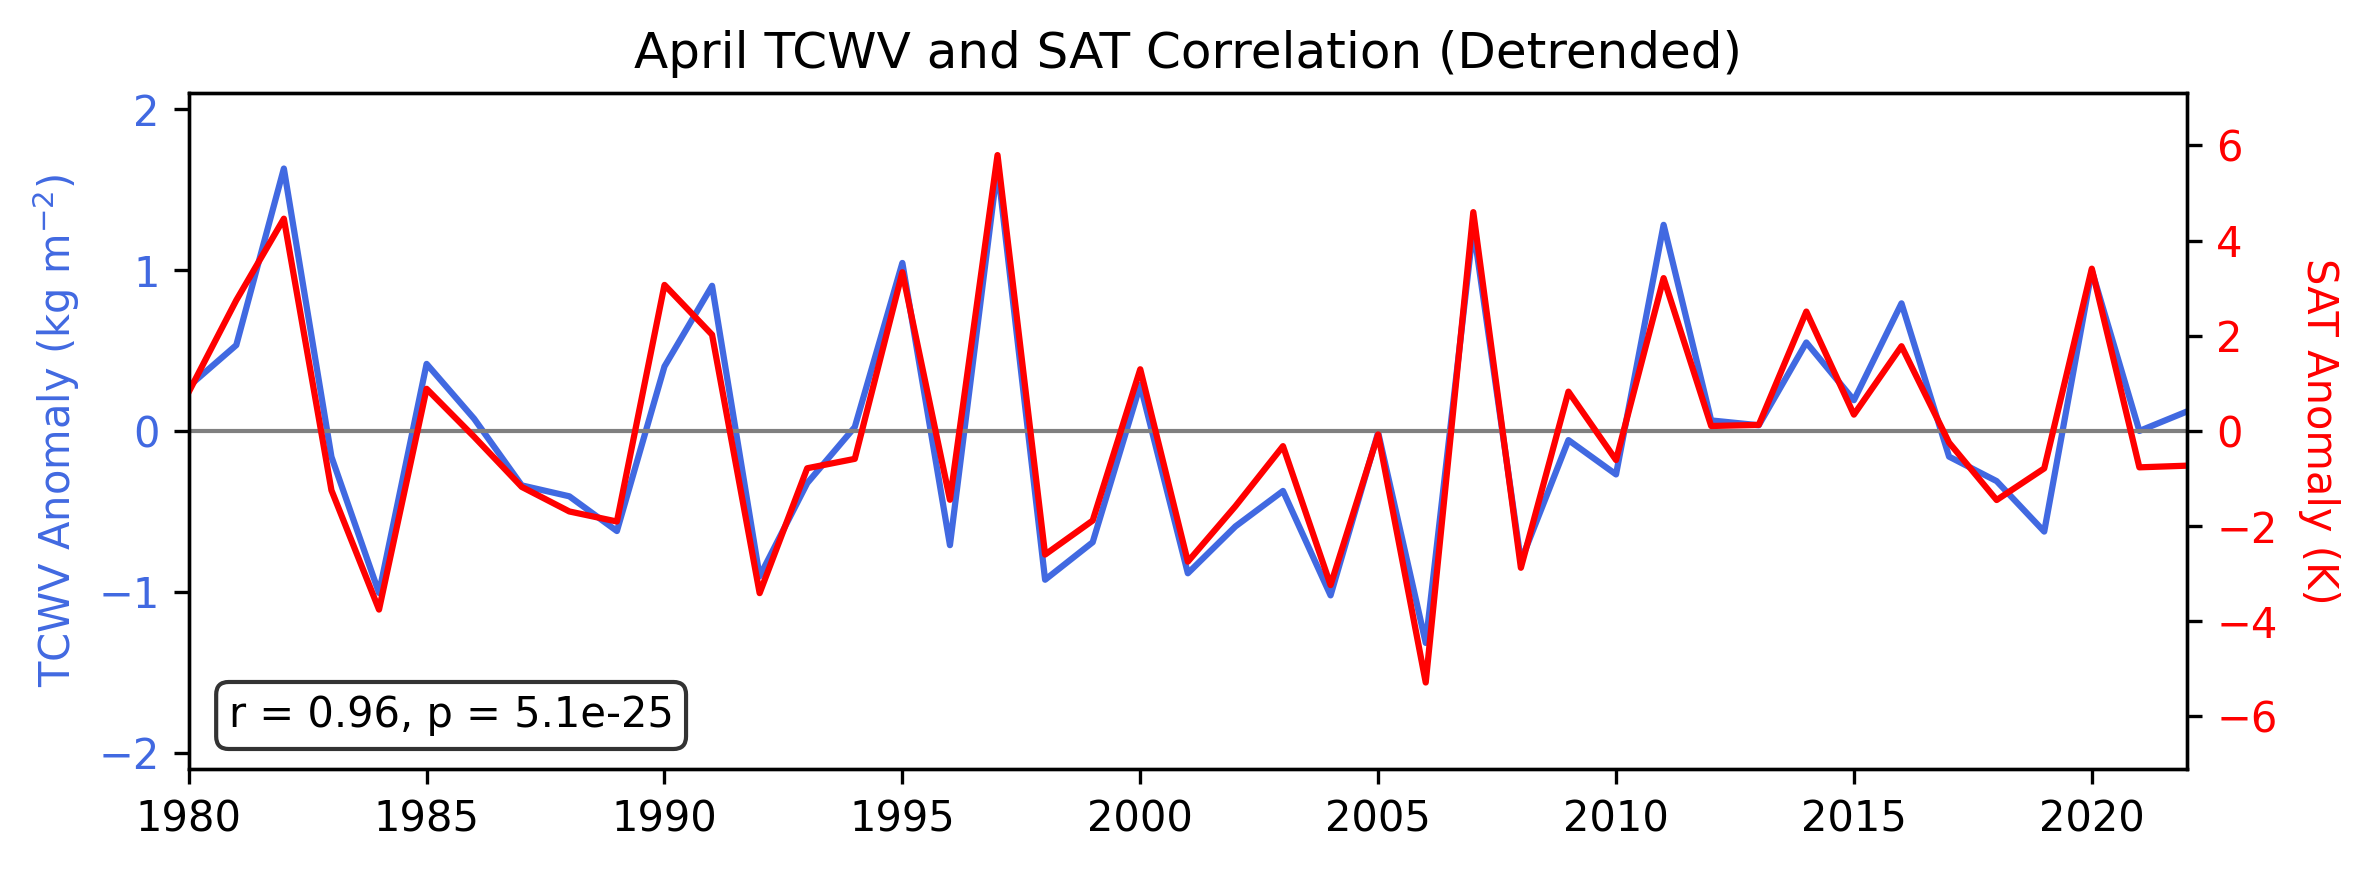

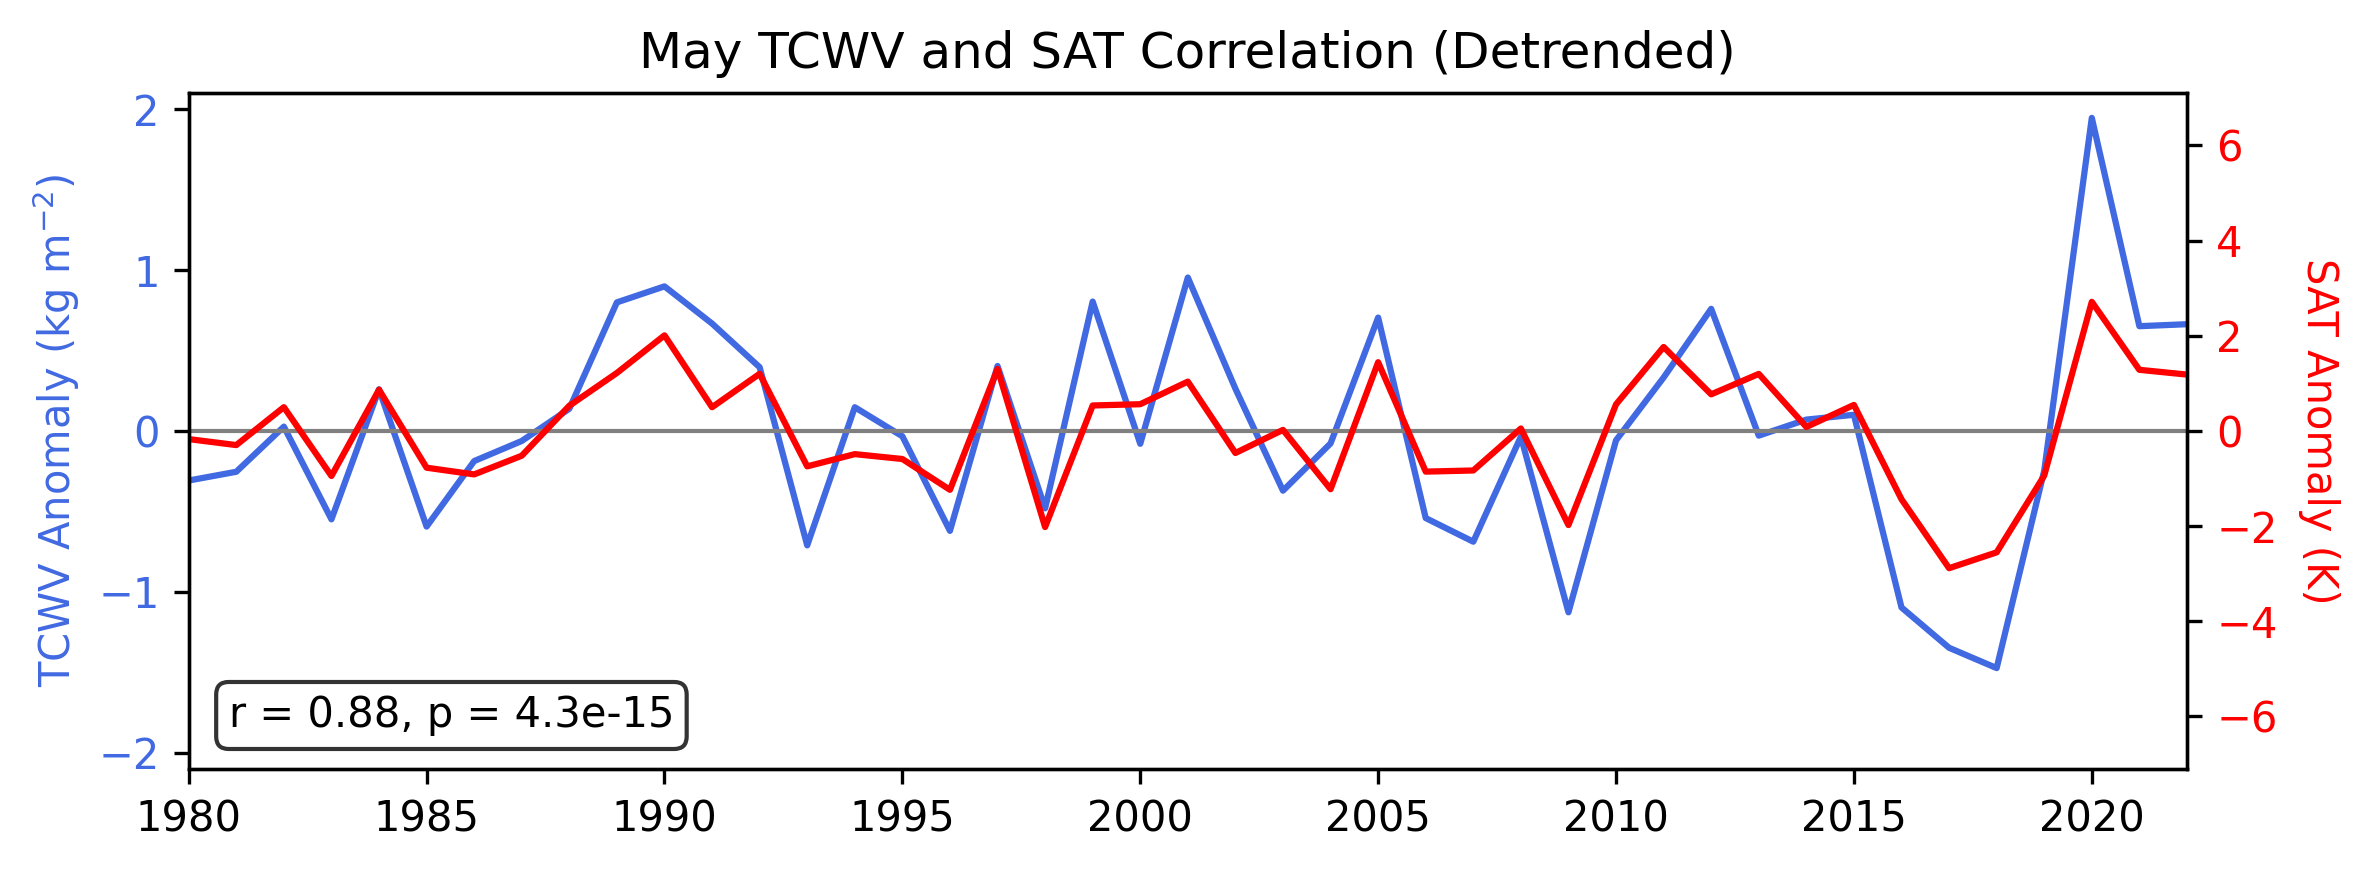

In [101]:
# --- Correlations and plots (same month) ---
years = np.arange(1980, 2023)
months = ["March", "April", "May"]

tcwv_color = 'royalblue'
sat_color = 'red'

for month in range(3):
    # Calculate correlation
    r, p = pearsonr(tcwv_dt[:, month], sat_dt[:, month])

    # Create figure and axes
    fig, ax1 = plt.subplots(figsize=(8, 3), dpi=300)
    ax2 = ax1.twinx()

    # Plot TCWV on left y-axis
    ln1 = ax1.plot(years, tcwv_dt[:, month], color=tcwv_color)
    ax1.set_ylabel('TCWV Anomaly (kg m$^{-2}$)', color=tcwv_color)
    ax1.tick_params(axis='y', labelcolor=tcwv_color)

    # Plot SAT on right y-axis
    ln2 = ax2.plot(years, sat_dt[:, month], color=sat_color)
    ax2.set_ylabel('SAT Anomaly (K)', color=sat_color, rotation=270, labelpad=15)
    ax2.tick_params(axis='y', labelcolor=sat_color)

    # Add correlation text box
    textstr = f'r = {r:.2f}, p = {p:.1e}'
    props = dict(boxstyle='round', facecolor='white', alpha=0.8)
    plt.text(0.02, 0.11, textstr, transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', bbox=props)
    
    ax1.set_ylim((-2.1, 2.1))
    ax2.set_ylim((-7.1, 7.1))
    ax1.axhline(y=0, color='gray', linewidth=1)

    # Title and settings
    plt.title(f'{months[month]} TCWV and SAT Correlation (Detrended)')
    plt.xlim(1980, 2022)

    plt.tight_layout()
    plt.savefig(f'../figures/interannual_variability/{months[month]}_TCWV_SAT.png', dpi=300)
    plt.show()


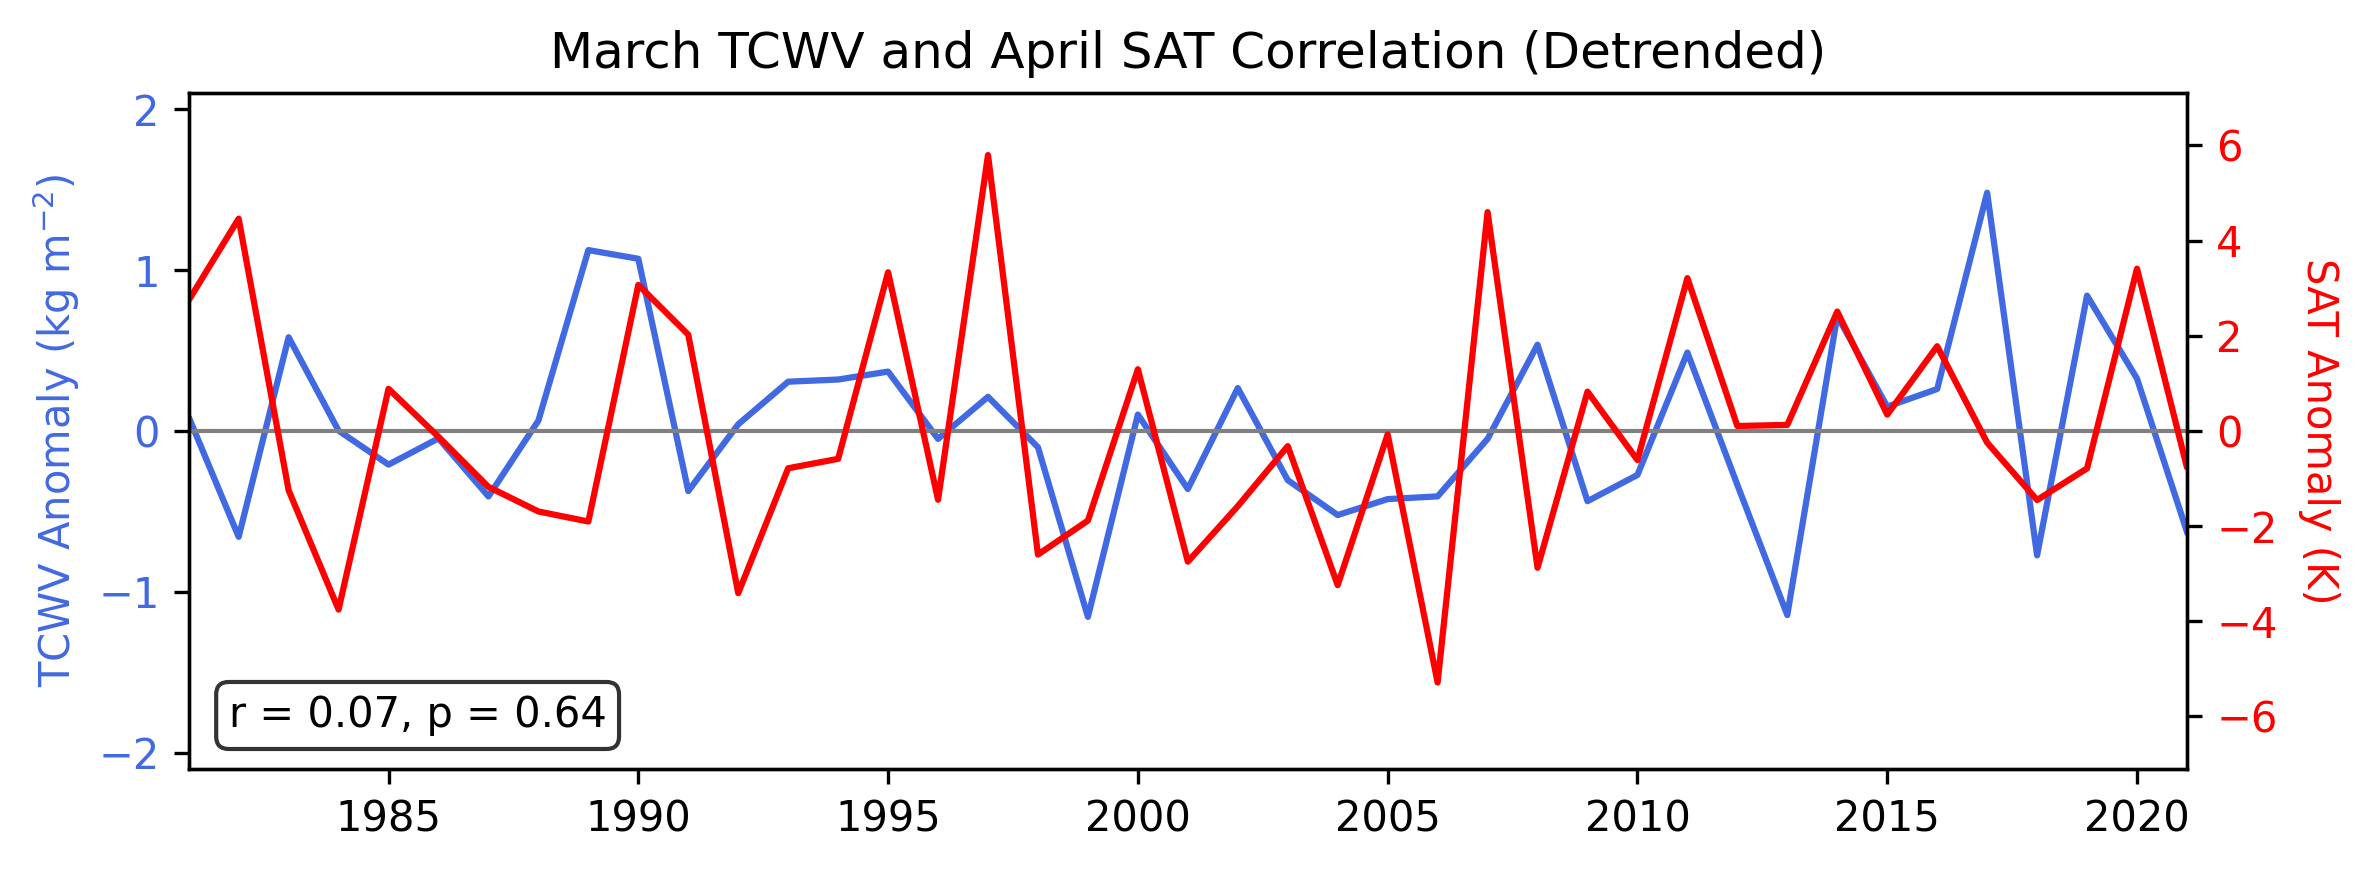

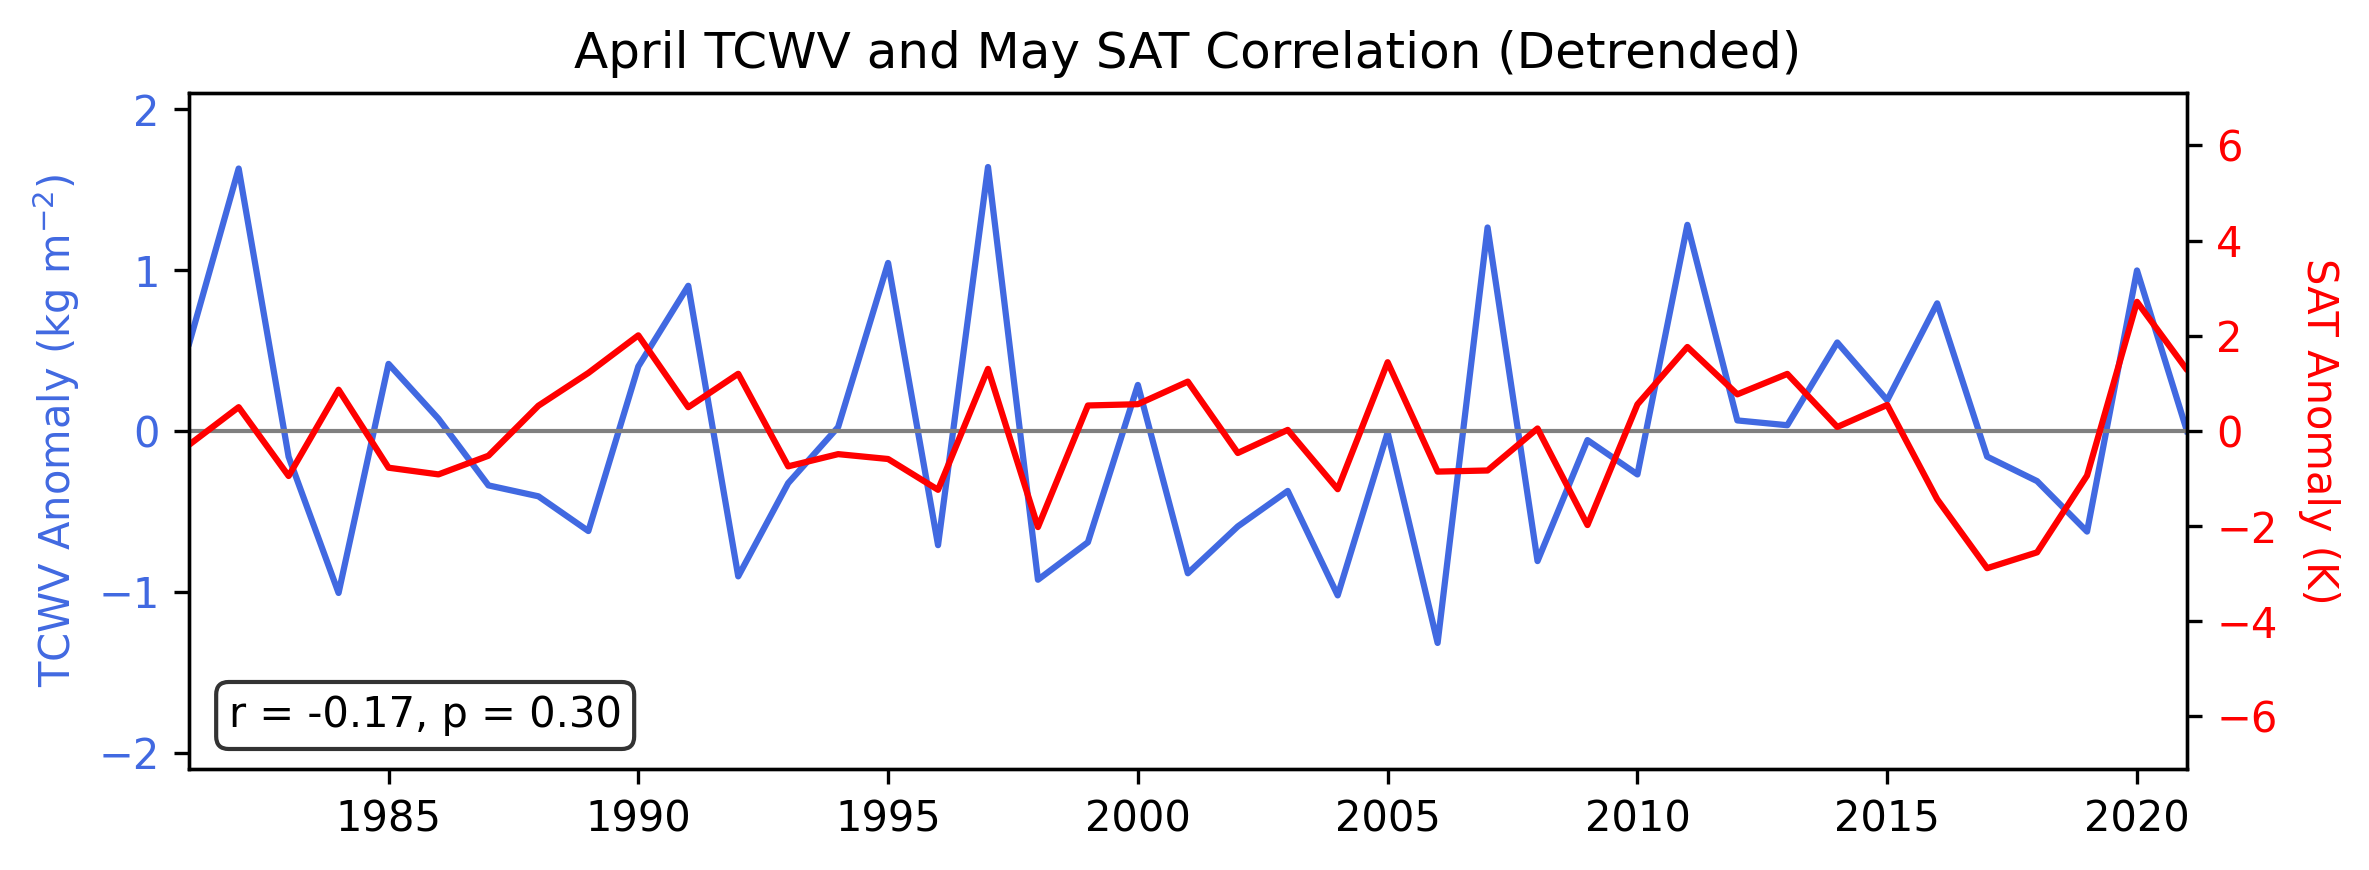

In [102]:
# --- Correlations and plots (prior month) ---
prior_pairs = [
    (0, 1),
    (1, 2)
]

for tcwv_month, sat_month in prior_pairs:
    # Compute correlation
    r, p = pearsonr(tcwv_dt[:-1, tcwv_month], sat_dt[1:, sat_month])

    # Create figure and axes
    fig, ax1 = plt.subplots(figsize=(8, 3), dpi=300)
    ax2 = ax1.twinx()

    # Plot TCWV (previous month)
    ln1 = ax1.plot(years[:-1], tcwv_dt[:-1, tcwv_month], color=tcwv_color)
    ax1.set_ylabel('TCWV Anomaly (kg m$^{-2}$)', color=tcwv_color)
    ax1.tick_params(axis='y', labelcolor=tcwv_color)

    # Plot SAT (current month)
    ln2 = ax2.plot(years[1:], sat_dt[1:, sat_month], color=sat_color)
    ax2.set_ylabel('SAT Anomaly (K)', color=sat_color, rotation=270, labelpad=15)
    ax2.tick_params(axis='y', labelcolor=sat_color)

    # Set y-limits to align zero lines
    ax1.set_ylim((-2.1, 2.1))
    ax2.set_ylim((-7.1, 7.1))

    # Add horizontal line at y=0
    ax1.axhline(y=0, color='gray', linewidth=1)

    # Add correlation text box
    textstr = f'r = {r:.2f}, p = {p:.2f}'
    props = dict(boxstyle='round', facecolor='white', alpha=0.8)
    ax1.text(0.02, 0.11, textstr, transform=ax1.transAxes, fontsize=10, verticalalignment='top', bbox=props)

    # Title and settings
    plt.title(f'{months[tcwv_month]} TCWV and {months[sat_month]} SAT Correlation (Detrended)')
    plt.xlim(1981, 2021)
    plt.tight_layout()
    plt.savefig(f'../figures/interannual_variability/{months[tcwv_month]}_TCWV_{months[sat_month]}_SAT.png', dpi=300)
    plt.show()


### SLP and SAT

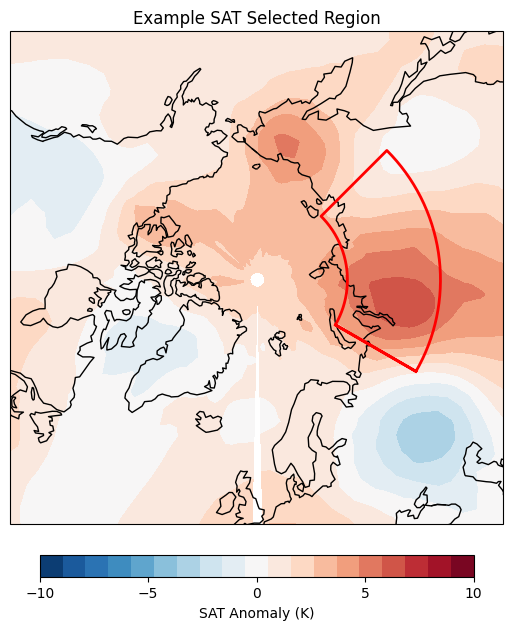

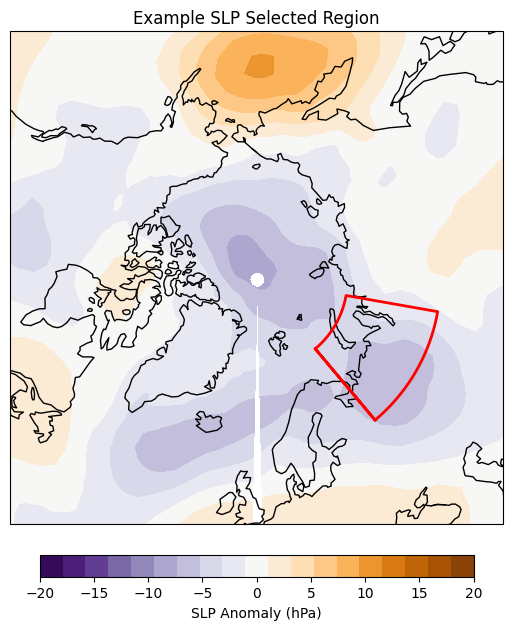

In [13]:
# Interannual correlations setup

# --- Get indices ---
def get_region_indices(lats, lons, region):
    lat_idx = (lats >= region['lat_min']) & (lats <= region['lat_max'])
    lon_idx = (lons >= region['lon_min']) & (lons <= region['lon_max'])
    return lat_idx, lon_idx


lats = ds.lat.values
lons = ds.lon.values

# Select region
sat_region = {'lat_min': 60, 'lat_max': 75, 'lon_min': 60, 'lon_max': 135}
slp_region = {'lat_min': 60, 'lat_max': 75, 'lon_min': 40, 'lon_max': 80}

sat_lat_idx, sat_lon_idx = get_region_indices(lats, lons, sat_region)
slp_lat_idx, slp_lon_idx = get_region_indices(lats, lons, slp_region)

# Check on maps
sat_lats = [sat_region['lat_min'], sat_region['lat_max'], sat_region['lat_max'], sat_region['lat_min'], sat_region['lat_min']]
sat_lons = [sat_region['lon_min'], sat_region['lon_min'], sat_region['lon_max'], sat_region['lon_max'], sat_region['lon_min']]
slp_lats = [slp_region['lat_min'], slp_region['lat_max'], slp_region['lat_max'], slp_region['lat_min'], slp_region['lat_min']]
slp_lons = [slp_region['lon_min'], slp_region['lon_min'], slp_region['lon_max'], slp_region['lon_max'], slp_region['lon_min']]

# Smooth region
def smooth_region(region, resolution):
   
    lons_top = np.linspace(region['lon_min'], region['lon_max'], resolution)
    lats_top = np.full_like(lons_top, region['lat_max'])
    lons_bottom = np.linspace(region['lon_max'], region['lon_min'], resolution)
    lats_bottom = np.full_like(lons_bottom, region['lat_min'])
    
    lats_left = np.linspace(region['lat_max'], region['lat_min'], resolution)
    lons_left = np.full_like(lats_left, region['lon_min'])
    lats_right = np.linspace(region['lat_min'], region['lat_max'], resolution)
    lons_right = np.full_like(lats_right, region['lon_max'])
    
    region_lons = np.concatenate([lons_top, lons_right, lons_bottom, lons_left])
    region_lats = np.concatenate([lats_top, lats_right, lats_bottom, lats_left])

    return region_lons, region_lats


sat_region_lons, sat_region_lats = smooth_region(sat_region, resolution=100)
slp_region_lons, slp_region_lats = smooth_region(slp_region, resolution=100)

# --- Plots ---
# SAT
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': ccrs.NorthPolarStereo()})
ax.set_extent([-180, 180, 50, 90], crs=ccrs.PlateCarree())

im = ax.contourf(
    lons, lats,
    SAT_maps[-1, -1],
    cmap="RdBu_r",
    levels=np.linspace(-10, 10, 20),
    transform=ccrs.PlateCarree()
)

cbar = fig.colorbar(im, ax=ax, orientation='horizontal', ticks=np.linspace(-10, 10, 5), shrink=0.7, pad=0.05)
cbar.set_label('SAT Anomaly (K)')

ax.plot(sat_region_lons, sat_region_lats, color='red', linewidth=2, transform=ccrs.PlateCarree())
ax.set_title('Example SAT Selected Region')
ax.grid(alpha=0.3)
ax.coastlines()
plt.show()

# SLP
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': ccrs.NorthPolarStereo()})
ax.set_extent([-180, 180, 50, 90], crs=ccrs.PlateCarree())

im = ax.contourf(
    lons, lats,
    SLP_maps[-1, -1],
    cmap="PuOr_r",
    levels=np.linspace(-20, 20, 20),
    transform=ccrs.PlateCarree()
)

cbar = fig.colorbar(im, ax=ax, orientation='horizontal', ticks=np.linspace(-20, 20, 9), shrink=0.7, pad=0.05)
cbar.set_label('SLP Anomaly (hPa)')

ax.plot(slp_region_lons, slp_region_lats, color='red', linewidth=2, transform=ccrs.PlateCarree())
ax.set_title('Example SLP Selected Region')
ax.grid(alpha=0.3)
ax.coastlines()
plt.show()


In [14]:
# --- Get regional average time series for each month ---
def spatial_average(array, lats):
    weights = np.cos(np.deg2rad(lats))
    weights_array = weights[np.newaxis, np.newaxis, :, np.newaxis]
    weighted_array = array * weights_array
    weighted_sum = np.nansum(weighted_array, axis=(2, 3))
    weights_sum = np.nansum(weights_array * ~np.isnan(array), axis=(2, 3))
    return weighted_sum / weights_sum


sat_ts = spatial_average(SAT_maps[:, :, sat_lat_idx, :][:, :, :, sat_lon_idx], lats[sat_lat_idx])
slp_ts = spatial_average(SLP_maps[:, :, slp_lat_idx, :][:, :, :, slp_lon_idx], lats[slp_lat_idx])

print(np.shape(sat_ts), np.shape(slp_ts))

(43, 3) (43, 3)


In [15]:
# --- Detrend ---
sat_dt = detrend(sat_ts, axis=0, type='linear')
slp_dt = detrend(slp_ts, axis=0, type='linear')


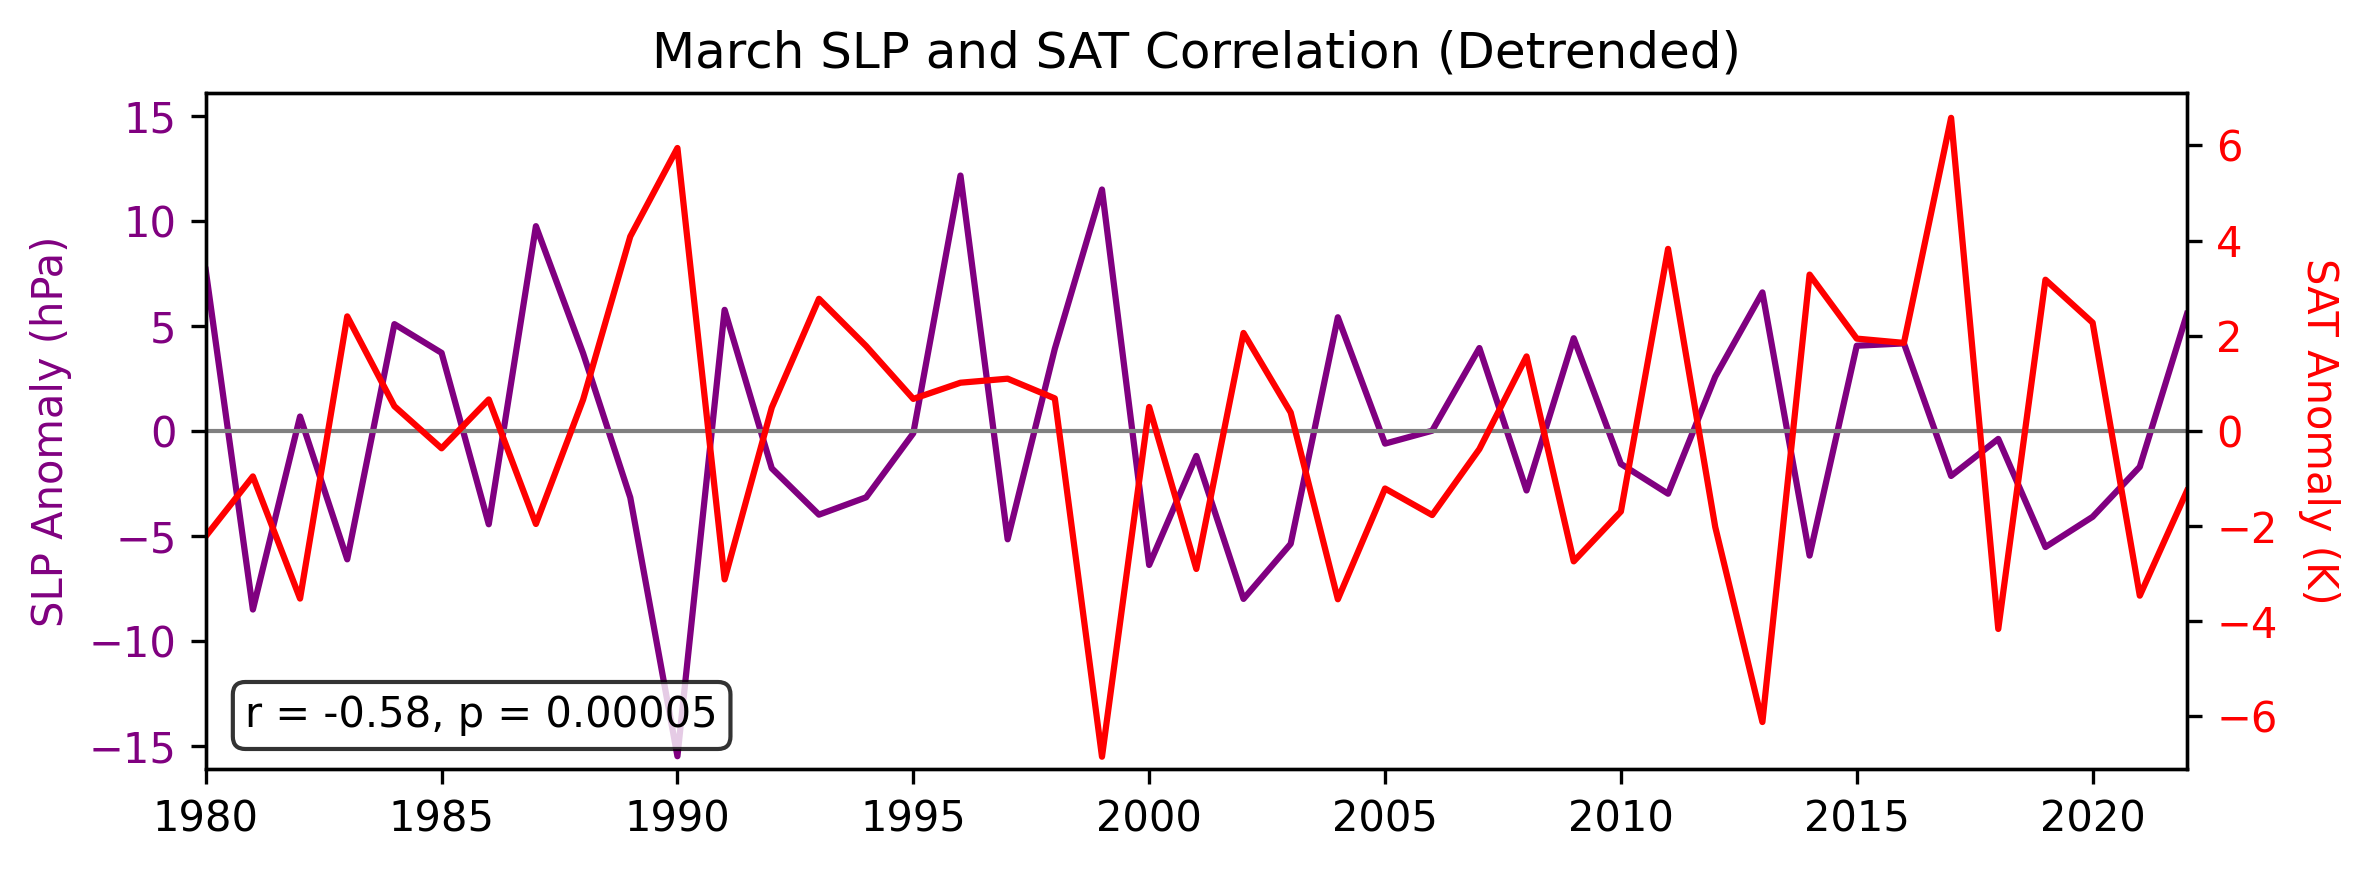

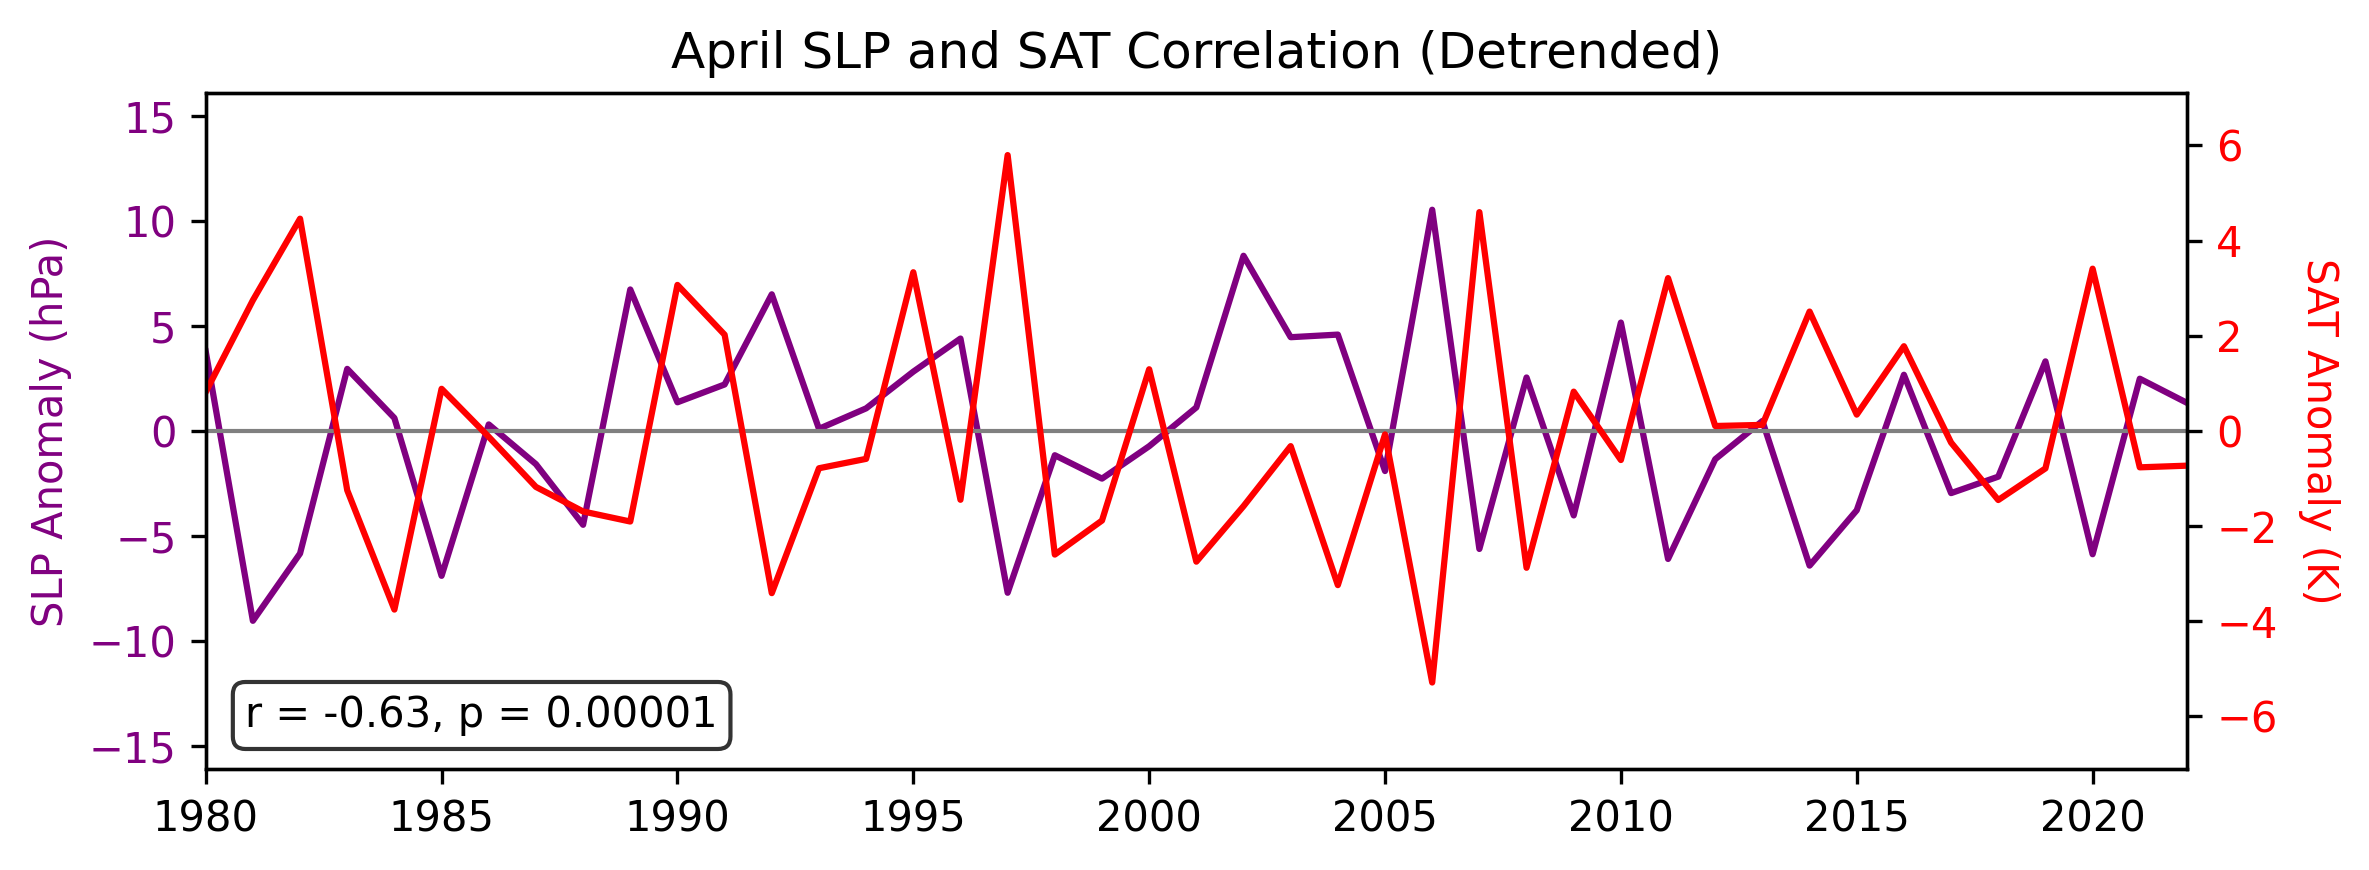

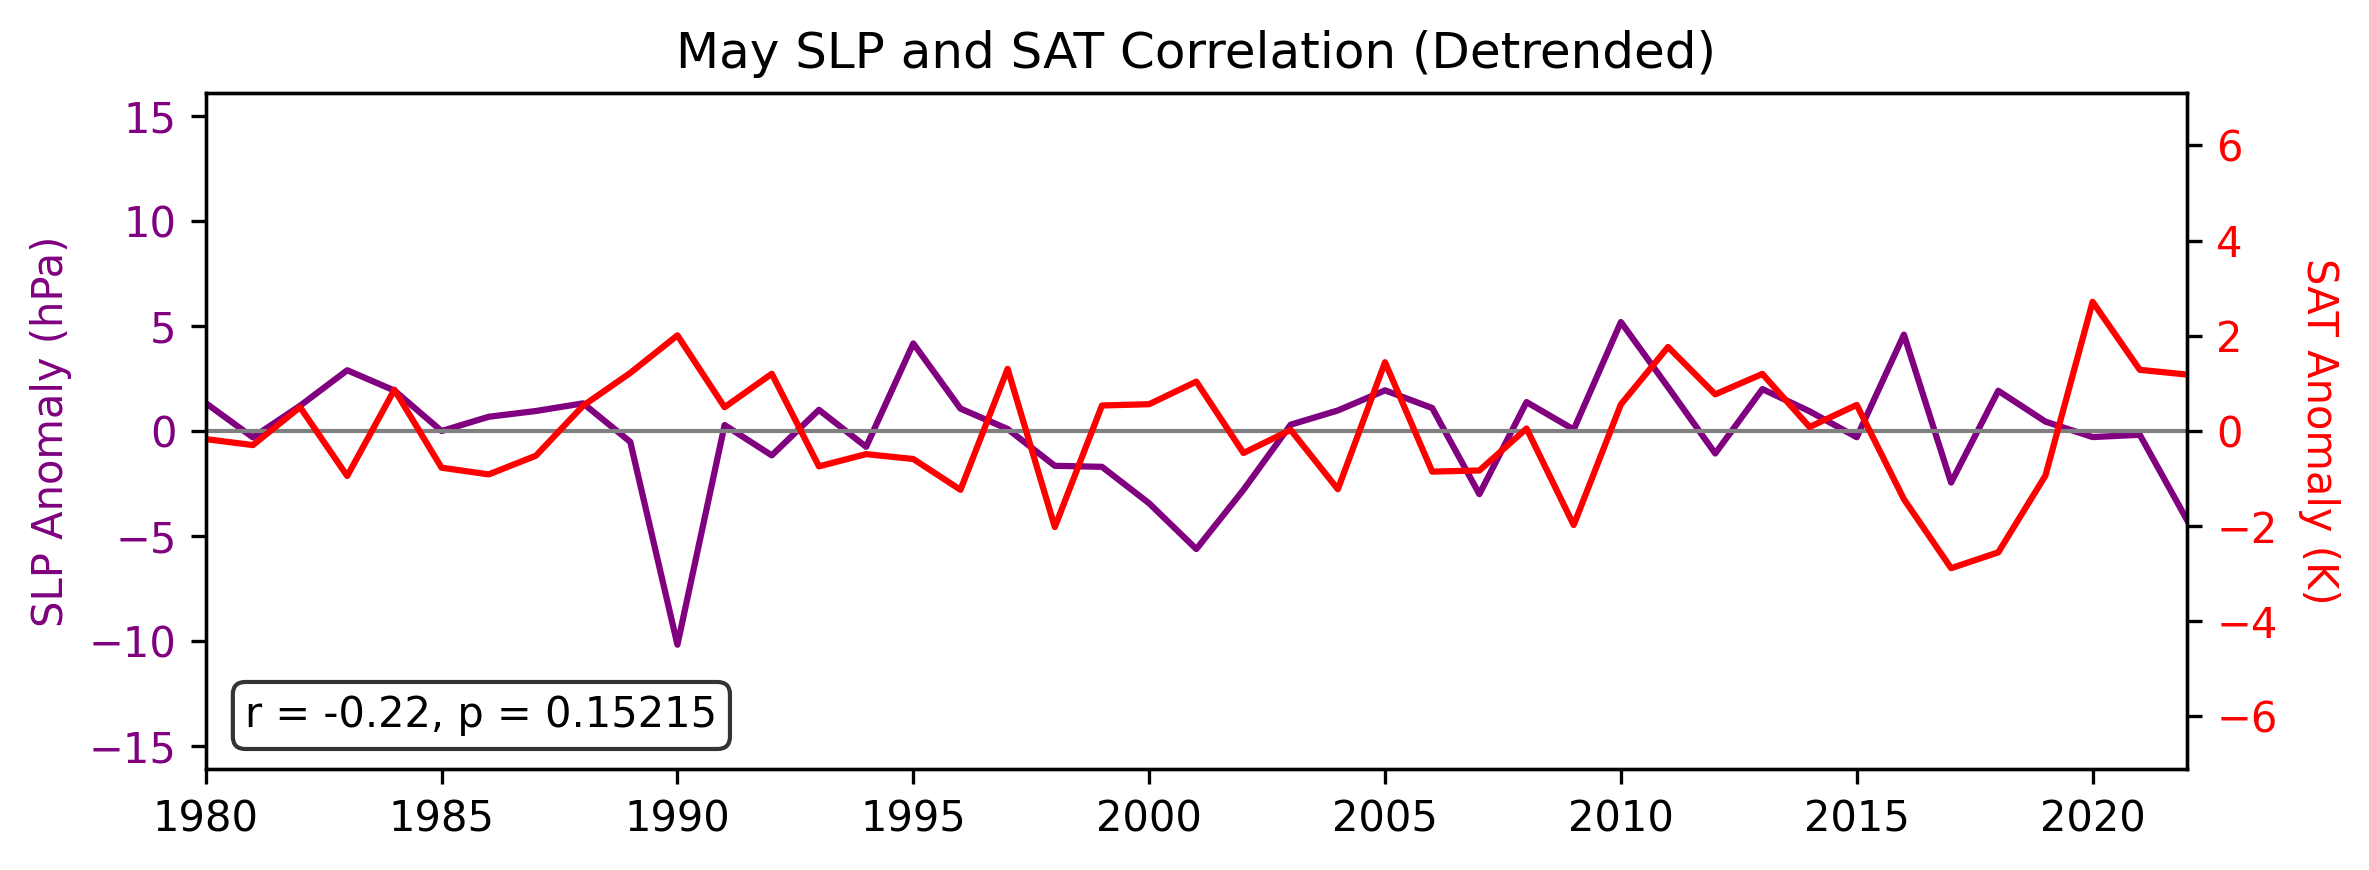

In [24]:
# --- Correlations and plots (same month) ---
years = np.arange(1980, 2023)
months = ["March", "April", "May"]

slp_color = 'purple'
sat_color = 'red'

for month in range(3):
    # Calculate correlation
    r, p = pearsonr(slp_dt[:, month], sat_dt[:, month])

    # Create figure and axes
    fig, ax1 = plt.subplots(figsize=(8, 3), dpi=300)
    ax2 = ax1.twinx()

    # Plot SLP on left y-axis
    ln1 = ax1.plot(years, slp_dt[:, month], color=slp_color)
    ax1.set_ylabel('SLP Anomaly (hPa)', color=slp_color)
    ax1.tick_params(axis='y', labelcolor=slp_color)

    # Plot SAT on right y-axis
    ln2 = ax2.plot(years, sat_dt[:, month], color=sat_color)
    ax2.set_ylabel('SAT Anomaly (K)', color=sat_color, rotation=270, labelpad=15)
    ax2.tick_params(axis='y', labelcolor=sat_color)

    # Add correlation text box
    textstr = f'r = {r:.2f}, p = {p:.5f}'
    props = dict(boxstyle='round', facecolor='white', alpha=0.8)
    plt.text(0.02, 0.11, textstr, transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', bbox=props)
    
    ax1.set_ylim((-16.1, 16.1))
    ax2.set_ylim((-7.1, 7.1))
    ax1.axhline(y=0, color='gray', linewidth=1)

    # Title and settings
    plt.title(f'{months[month]} SLP and SAT Correlation (Detrended)')
    plt.xlim(1980, 2022)

    plt.tight_layout()
    # plt.savefig(f'../figures/interannual_variability/{months[month]}_TCWV_SAT.png', dpi=300)
    plt.show()


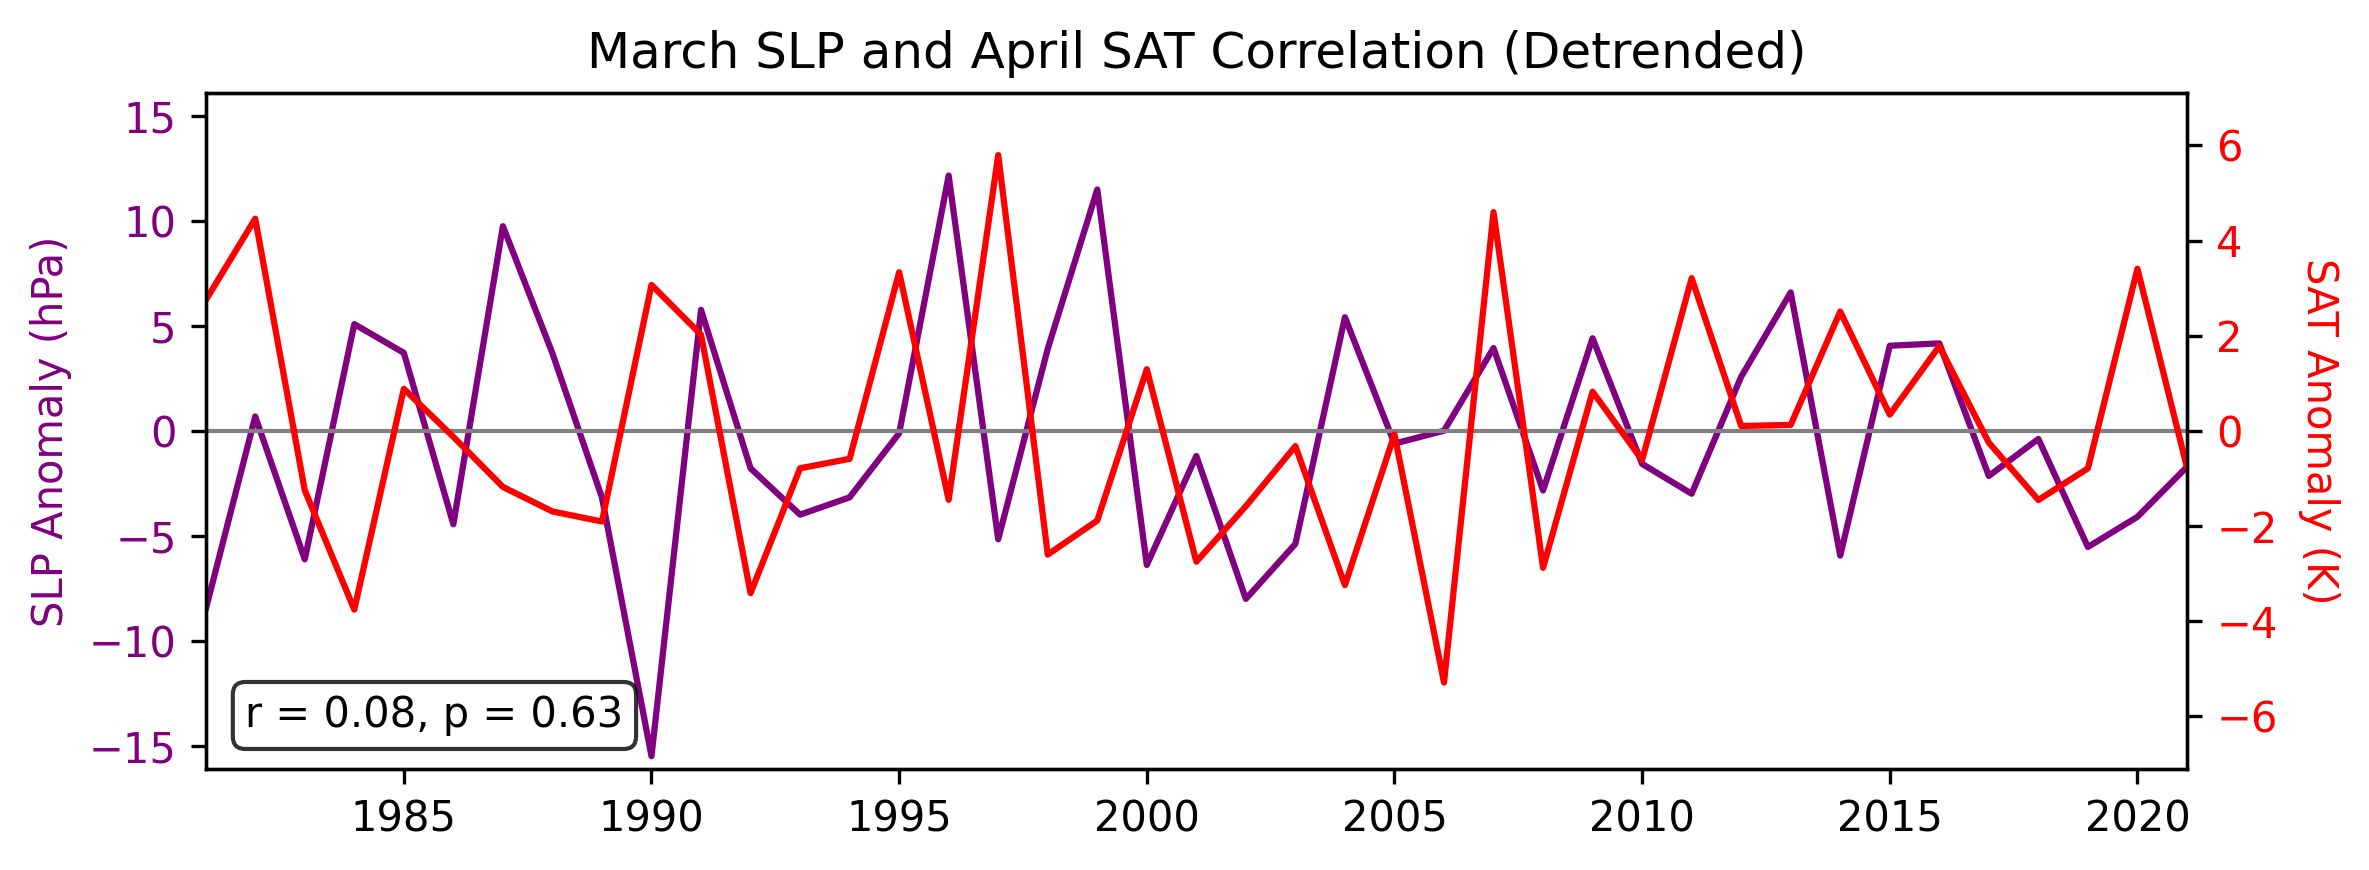

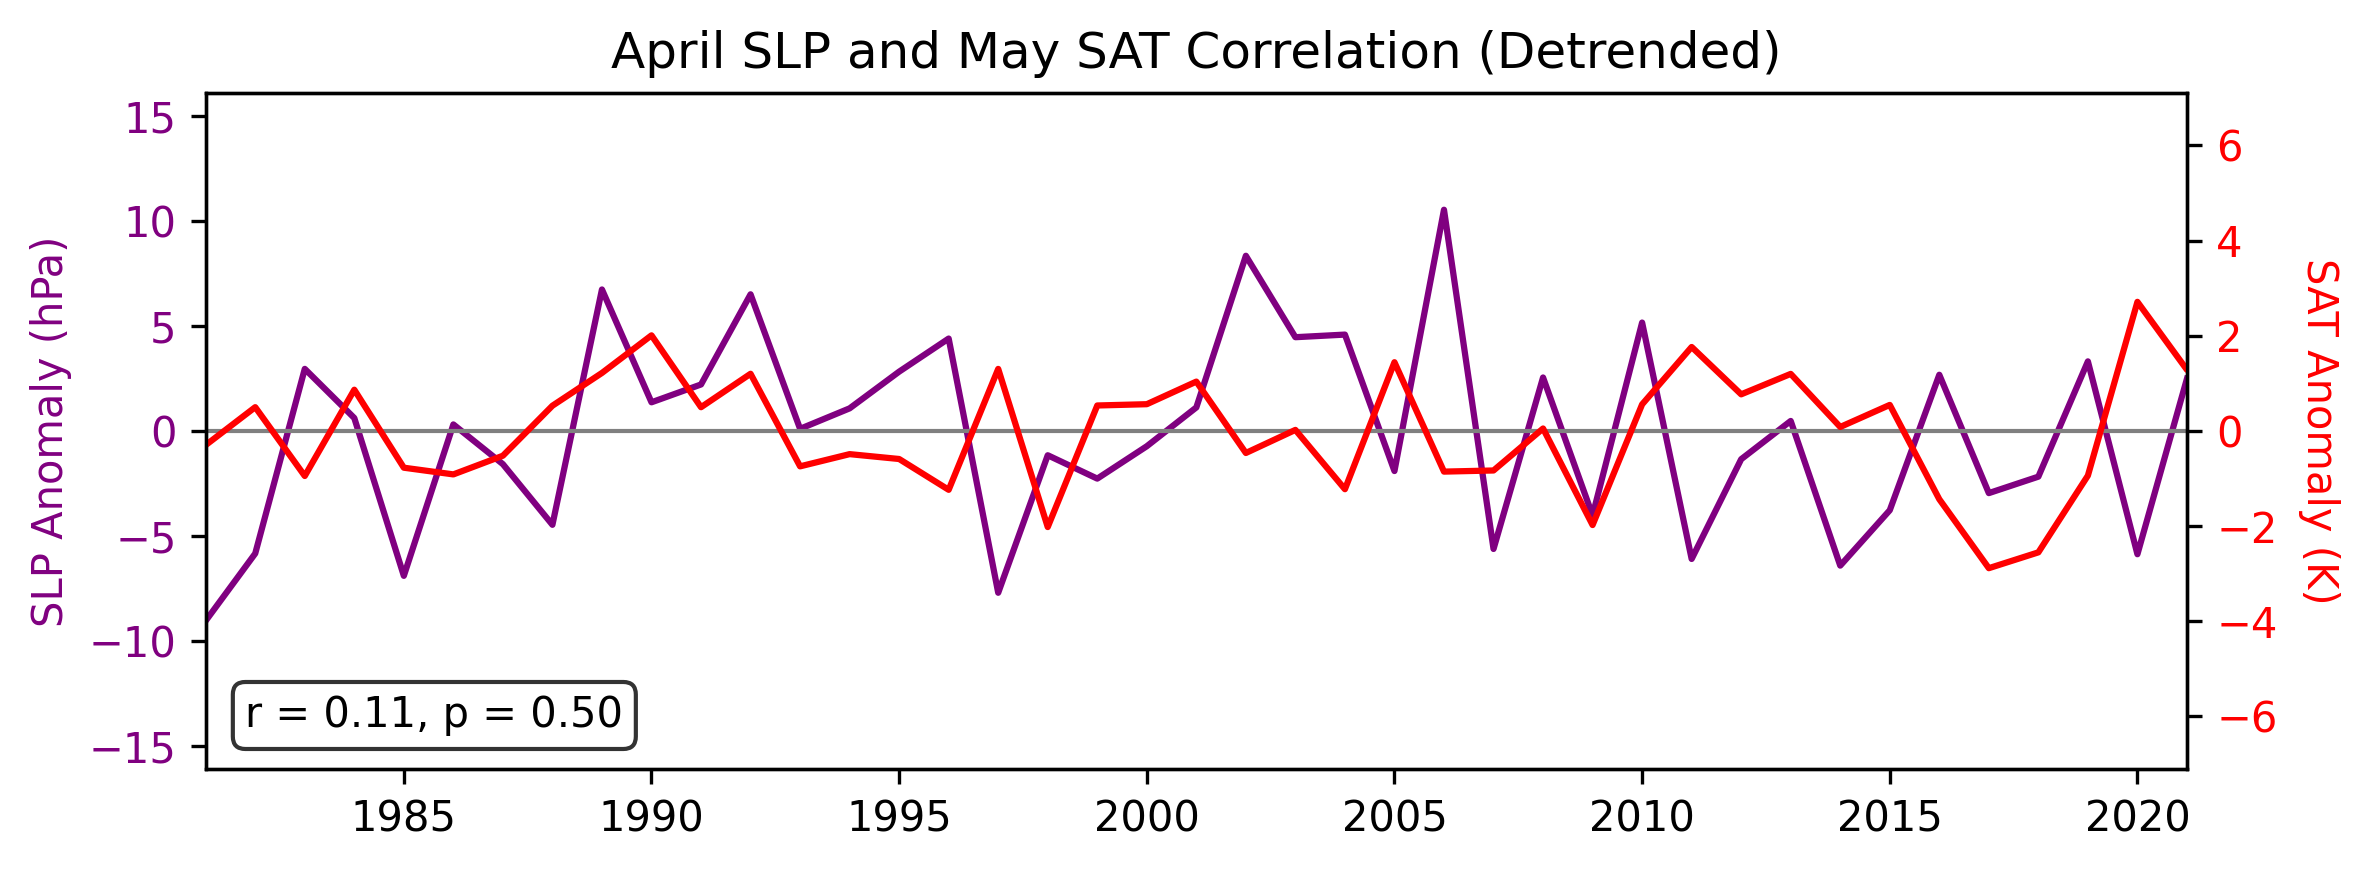

In [27]:
# --- Correlations and plots (prior month) ---
prior_pairs = [
    (0, 1),
    (1, 2)
]

for slp_month, sat_month in prior_pairs:
    # Compute correlation
    r, p = pearsonr(slp_dt[:-1, slp_month], sat_dt[1:, sat_month])

    # Create figure and axes
    fig, ax1 = plt.subplots(figsize=(8, 3), dpi=300)
    ax2 = ax1.twinx()

    # Plot TCWV (previous month)
    ln1 = ax1.plot(years[:-1], slp_dt[:-1, slp_month], color=slp_color)
    ax1.set_ylabel('SLP Anomaly (hPa)', color=slp_color)
    ax1.tick_params(axis='y', labelcolor=slp_color)

    # Plot SAT (current month)
    ln2 = ax2.plot(years[1:], sat_dt[1:, sat_month], color=sat_color)
    ax2.set_ylabel('SAT Anomaly (K)', color=sat_color, rotation=270, labelpad=15)
    ax2.tick_params(axis='y', labelcolor=sat_color)

    # Set y-limits to align zero lines
    ax1.set_ylim((-16.1, 16.1))
    ax2.set_ylim((-7.1, 7.1))

    # Add horizontal line at y=0
    ax1.axhline(y=0, color='gray', linewidth=1)

    # Add correlation text box
    textstr = f'r = {r:.2f}, p = {p:.2f}'
    props = dict(boxstyle='round', facecolor='white', alpha=0.8)
    ax1.text(0.02, 0.11, textstr, transform=ax1.transAxes, fontsize=10, verticalalignment='top', bbox=props)

    # Title and settings
    plt.title(f'{months[slp_month]} SLP and {months[sat_month]} SAT Correlation (Detrended)')
    plt.xlim(1981, 2021)
    plt.tight_layout()
    # plt.savefig(f'../figures/interannual_variability/{months[tcwv_month]}_TCWV_{months[sat_month]}_SAT.png', dpi=300)
    plt.show()


### March and April SAT

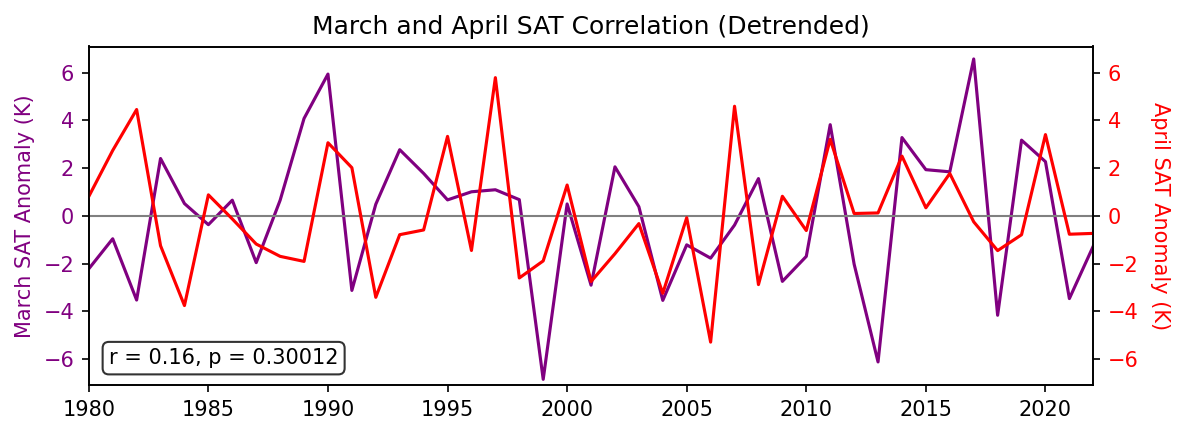

In [29]:
# --- Correlations and plots (same month) ---
years = np.arange(1980, 2023)

march_color = 'purple'
april_color = 'red'

# Calculate correlation
r, p = pearsonr(sat_dt[:, 0], sat_dt[:, 1])

# Create figure and axes
fig, ax1 = plt.subplots(figsize=(8, 3), dpi=150)
ax2 = ax1.twinx()

# Plot March SAT on left y-axis
ln1 = ax1.plot(years, sat_dt[:, 0], color=march_color)
ax1.set_ylabel('March SAT Anomaly (K)', color=march_color)
ax1.tick_params(axis='y', labelcolor=march_color)

# Plot April SAT on right y-axis
ln2 = ax2.plot(years, sat_dt[:, 1], color=april_color)
ax2.set_ylabel('April SAT Anomaly (K)', color=april_color, rotation=270, labelpad=15)
ax2.tick_params(axis='y', labelcolor=april_color)

# Add correlation text box
textstr = f'r = {r:.2f}, p = {p:.5f}'
props = dict(boxstyle='round', facecolor='white', alpha=0.8)
plt.text(0.02, 0.11, textstr, transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', bbox=props)

ax1.set_ylim((-7.1, 7.1))
ax2.set_ylim((-7.1, 7.1))
ax1.axhline(y=0, color='gray', linewidth=1)

# Title and settings
plt.title('March and April SAT Correlation (Detrended)')
plt.xlim(1980, 2022)

plt.tight_layout()
# plt.savefig(f'../figures/interannual_variability/{months[month]}_TCWV_SAT.png', dpi=300)
plt.show()
